In [44]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os
import numpy as np
import pandas as pd
from joblib import dump, load
from time import time
from sklearn.feature_selection import RFECV
import json

## LOAD FILES

In [18]:
#LOAD MODEL

RFC_path='RFC_FullData.joblib'
RFC = load(RFC_path) 

In [19]:
#LOAD DATA
dataDir = 'CleanDataFinal'

#LOAD TRAINING DATA
#features
path = os.path.join(dataDir, 'trainFeaturesFinal.csv')
train_x_pd = pd.read_csv (path, index_col = 'HHX')
train_x = train_x_pd.to_numpy()
print(train_x.shape)

#target
path = os.path.join(dataDir, 'trainTargetFinal.csv')
train_y_pd = pd.read_csv (path, index_col = 'HHX')
train_y = train_y_pd.to_numpy().flatten()
print(train_y.shape)

#LOAD TESTING DATA
#features
path = os.path.join(dataDir, 'testFeaturesFinal.csv')
test_x_pd = pd.read_csv (path, index_col = 'HHX')
test_x = test_x_pd.to_numpy()
print(test_x.shape)

#target
path = os.path.join(dataDir, 'testTargetFinal.csv')
test_y_pd = pd.read_csv (path, index_col = 'HHX')
test_y = test_y_pd.to_numpy().flatten()
print(test_y.shape)

(22222, 5290)
(22222,)
(5556, 5290)
(5556,)


## FEATURE IMPORTANCE USING PERMUTATION IMPORTANCE ALGORITHM

In [45]:
#adapted from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

start_time = time()
result = permutation_importance(
    RFC, test_x, test_y, n_repeats=10, random_state=42, n_jobs=2, scoring='roc_auc_ovr_weighted')
elapsed_time = time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 40230.287 seconds


In [46]:
forest_importances = pd.Series(result.importances_mean, index=test_x_pd.columns)
forest_std = pd.Series(result.importances_std, index=test_x_pd.columns)

#save data
path = 'FeatureImportanceFullData.csv'
forest_importances.to_csv(path)
path = 'FeatureImportanceSTDFullData.csv'
forest_importances.to_csv(path)


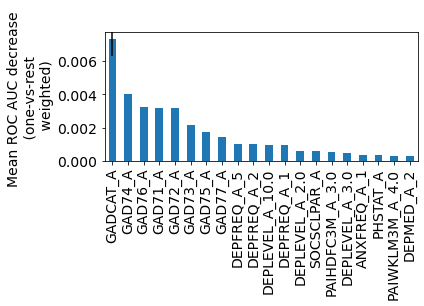

In [49]:
#plot top feature importance

#sort data
forest_importances = forest_importances.sort_values(ascending=False)
#grab top few features
num_features = 20
top_features = forest_importances.iloc[:num_features]
top_features_STD = forest_std.iloc[:num_features]

#plot top features
fig, ax = plt.subplots(figsize=(6, 4))
top_features.plot.bar(yerr=top_features_STD, ax=ax, fontsize=14)
ax.set_ylabel("Mean ROC AUC decrease \n (one-vs-rest \n weighted)", fontsize=14)
fig.tight_layout()

#save figure
path='FullData_FeatureImportance.png'
plt.savefig(path, bbox_inches="tight")

plt.show()



## FEATURE SELECTION USING RECURSIVE FEATURE SELECTION

In [ ]:
#RUN FEATURE SELECTION ON FULL DATASET
#Adapted from https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

# Create the RFE object and compute a cross-validated score.
# Using same parameters as best Full data model 
## Wasn't seeing huge changes in scores for the different models
start_time = time()

n_estimators=461
max_features=118
RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)

step=20
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=RFC,
    step=step,
    scoring="roc_auc_ovr_weighted",
    min_features_to_select=min_features_to_select)

rfecv.fit(train_x, train_y)

print("Optimal number of features : %d" % rfecv.n_features_)
elapsed_time = time() - start_time
print(f"Elapsed time to select features: {elapsed_time:.3f} seconds")

In [ ]:
#SAVE DATA 
resPD = pd.DataFrame(rfecv.cv_results_)

features_max = train_x.shape[1]
features_min = features_max-(len(resPD)-1)*step
features_used = np.linspace(features_max, features_min, len(resPD))
resPD['features_used'] = features_used

dataDir = 'FeatureSelection'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)

dataFile = 'FeatureSelection_cv_results.csv'
path = os.path.join(dataDir, dataFile)

resPD.to_csv(path)

selected_features = pd.DataFrame(rfecv.ranking_, columns=['Ranking'])
selected_features['FeatureName'] = train_x_pd.columns.to_list()

dataFile = 'FeatureSelection_SelectedFeatures.csv'
path = os.path.join(dataDir, dataFile)

selected_features.to_csv(path)

In [54]:
#LOAD DATA 

dataDir = 'FeatureSelection'

dataFile = 'FeatureSelection_cv_results.csv'
path = os.path.join(dataDir, dataFile)
resPD = pd.read_csv(path, index_col=0)

dataFile = 'FeatureSelection_SelectedFeatures.csv'
path = os.path.join(dataDir, dataFile)
selected_features = pd.read_csv(path, index_col=0)

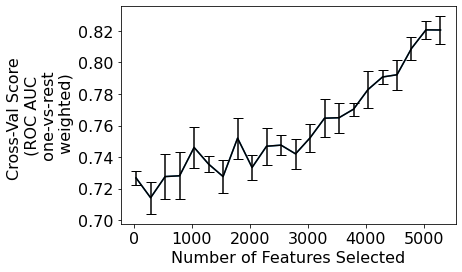

In [55]:
#GRAPH CV SCORE VS NUMBER OF FEATURES

# Plot number of features VS. cross-validation scores
plt.plot(resPD.features_used, resPD.mean_test_score)
plt.errorbar(resPD.features_used, resPD.mean_test_score, yerr=resPD.std_test_score, capsize=5, markeredgewidth=1, color='k')
plt.xlabel("Number of Features Selected", fontsize=16)
plt.ylabel("Cross-Val Score \n (ROC AUC \n one-vs-rest \n weighted)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#save figure
path='FeatureSelection.png'
plt.savefig(path, bbox_inches="tight")

plt.show()